TODO: Migrate to a colab notebook 

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

/Users/jason/Local/school/590/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 172k/172k [00:00<00:00, 7.35MB/s]

Extracting files...
Path to dataset files: /Users/jason/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [4]:
!ls $path

WA_Fn-UseC_-Telco-Customer-Churn.csv


In [5]:
import pandas as pd

In [7]:
df = pd.read_csv(path + f"/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [8]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


Tasks: 
- Exploratory Data Analysis to check Assumptions: Perform an exploratory analysis of the dataset to understand the relationships between different features and the target variable (churn). Use appropriate visualizations and statistical methods to determine whether assumptions about linear, logistic, and GAM models are met. 
- Linear Regression: Treat the churn variable as a continuous variable (e.g., 0 for staying, 1 for churning) and build a linear regression model to predict churn. Interpret the coefficients and assess the model's performance.
- Logistic Regression: Treat churn as a binary variable and build a logistic regression model to predict the probability of churn. Interpret the coefficients.
- Generalized Additive Model (GAM): Build a GAM to model the non-linear relationships between customer features and churn. Interpret the GAM model. 
- Model Comparison: Compare the performance and interpretability of the different models you built. Discuss the strengths and weaknesses of each approach and provide recommendations for which model(s) the telecommunications company should use to address their customer churn problem.

In [14]:
import matplotlib.pyplot as plt 

In [20]:
def plot_categorical(df, col): 
    counts = df[col].value_counts()
    # One-liner for mapping value-counts into a pyplot-friendly invocation courtest of gpt-5, see: https://chatgpt.com/share/68c2a9e7-2cf8-8004-a9a2-9cc92aacd6ab
    plt.bar(counts.index.astype(str), counts.values)

In [30]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

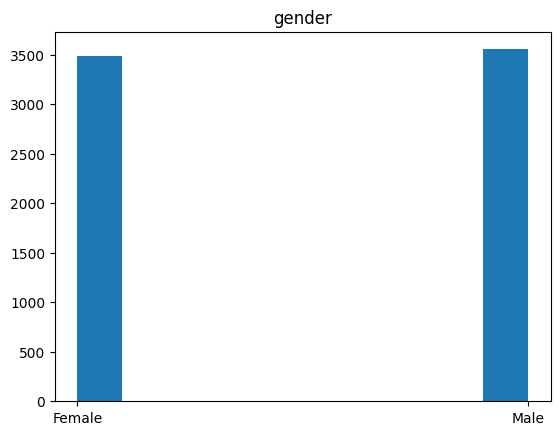

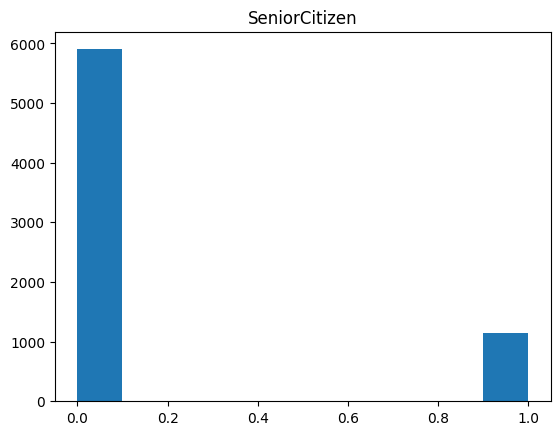

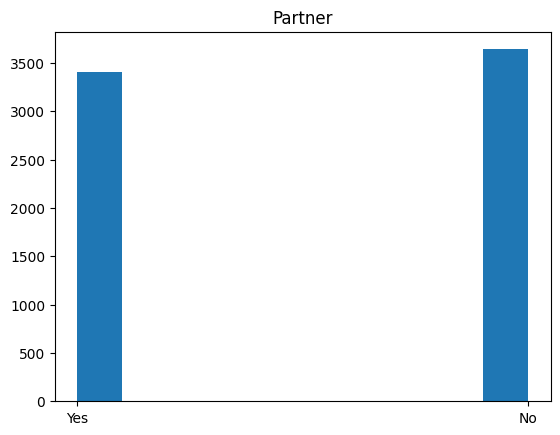

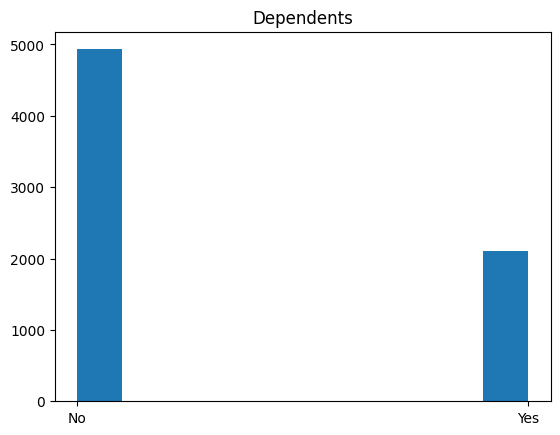

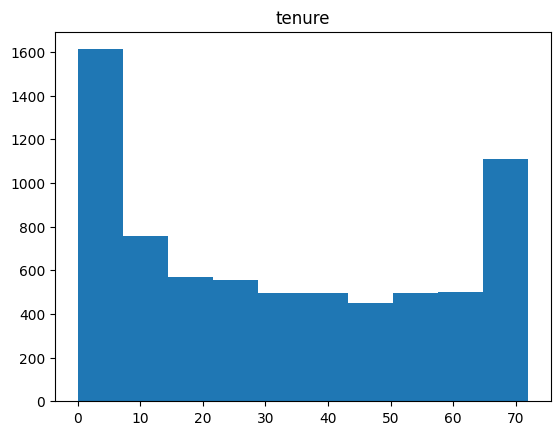

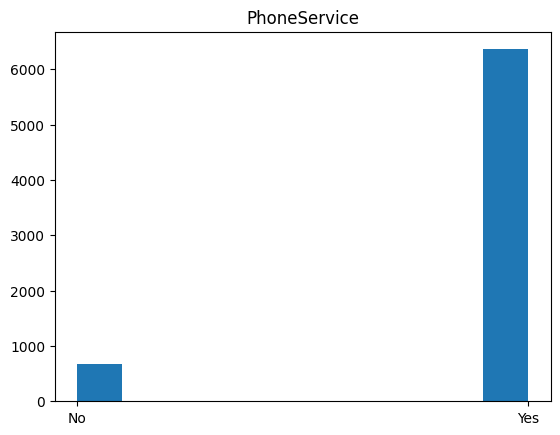

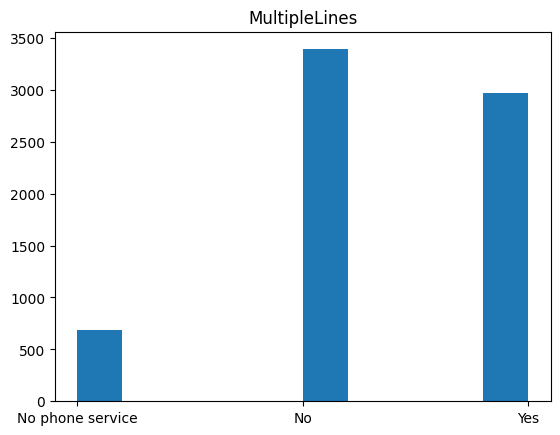

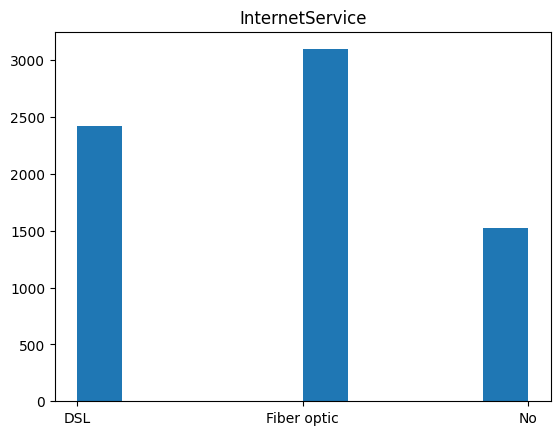

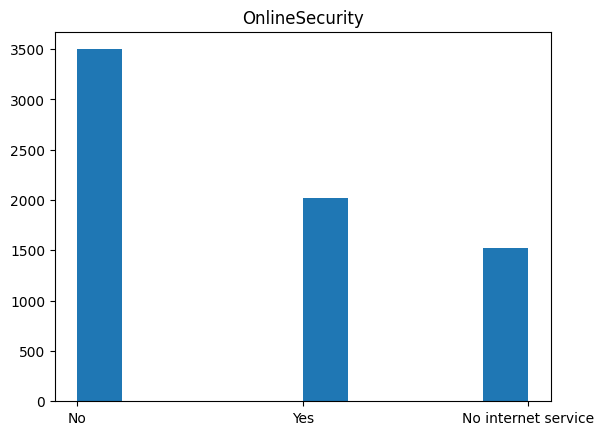

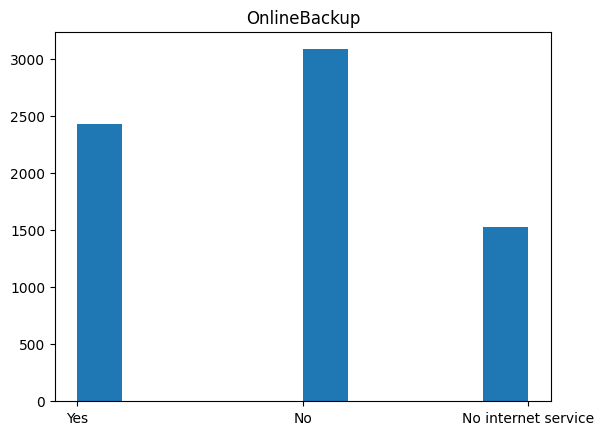

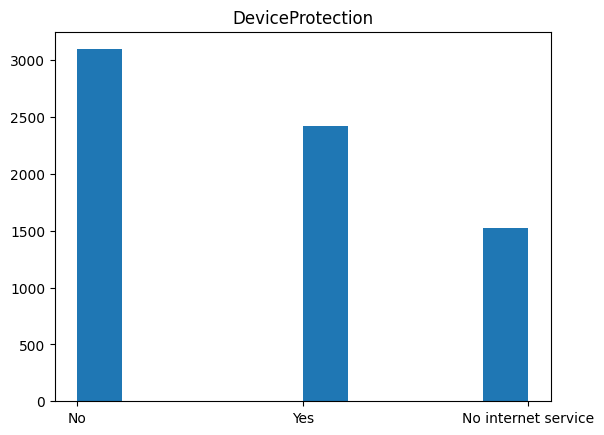

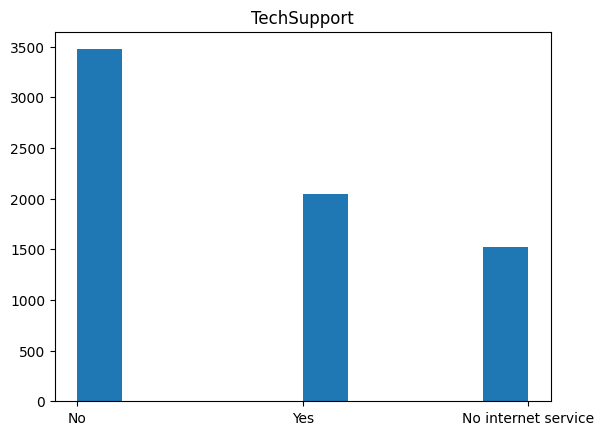

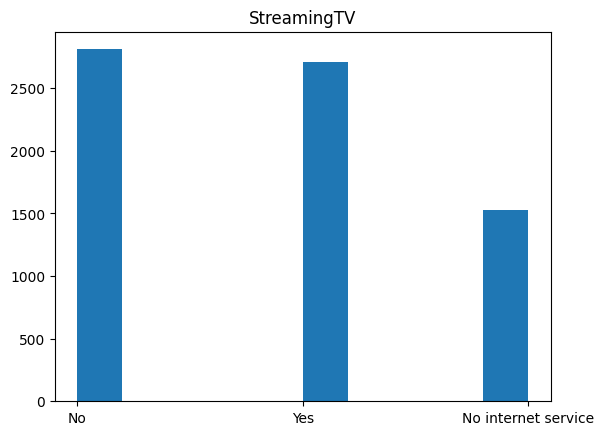

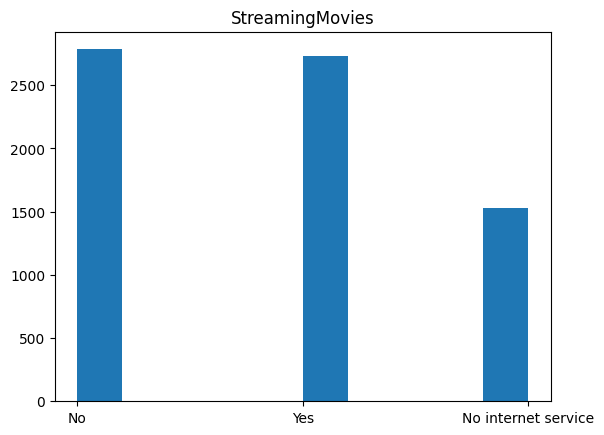

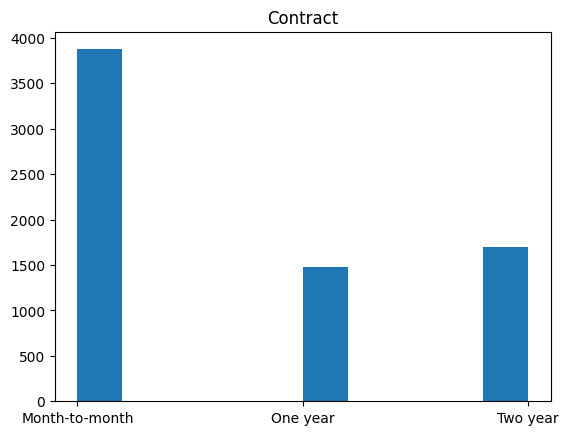

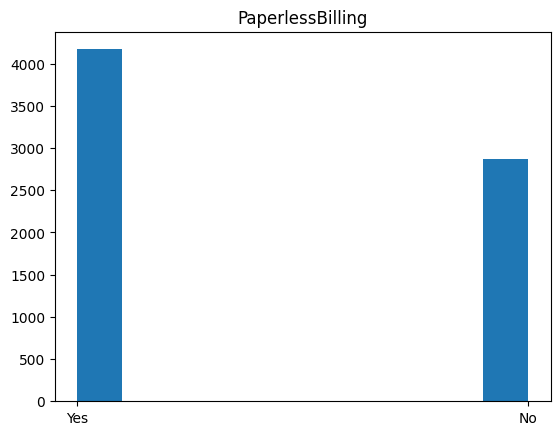

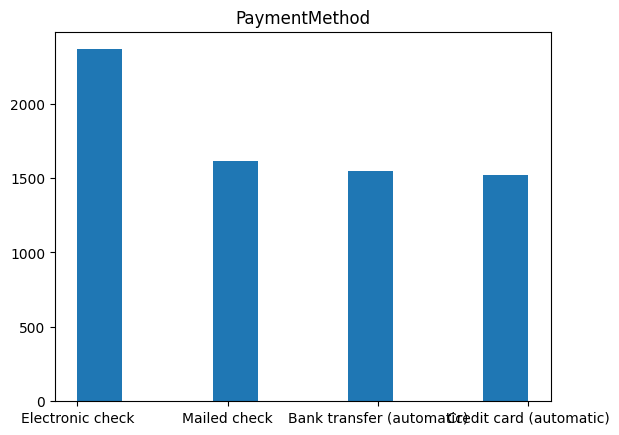

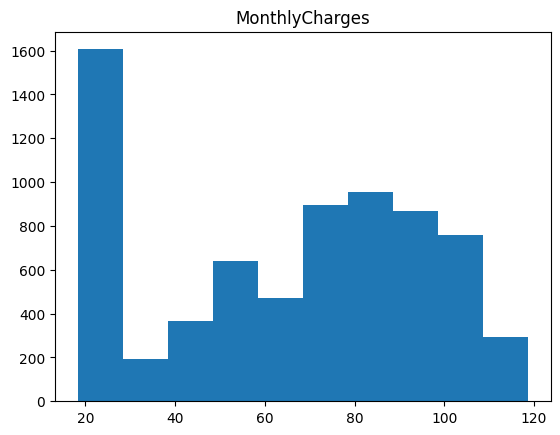

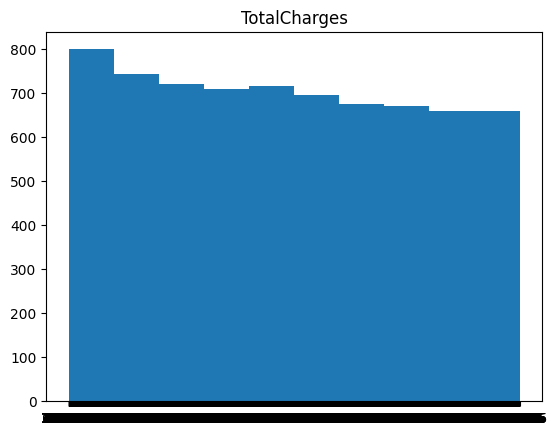

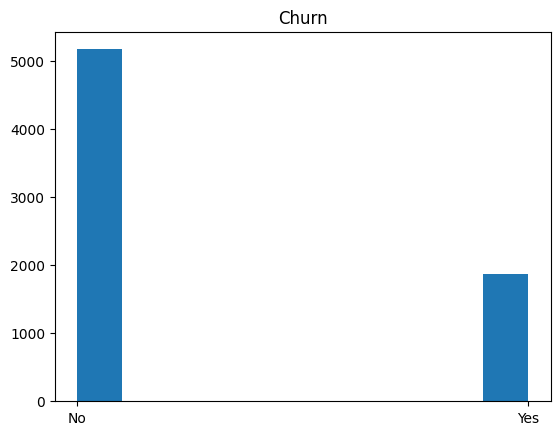

In [36]:
for col in ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']: 
     plt.hist(df[col])
     plt.title(col)
     plt.show()
     